# Import Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Import Colab Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change images re-size, normalize

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Images Folder Laders

In [5]:
train_dataset_path = "/content/drive/MyDrive/Tumor Dataset/Tea_Leaf_Disease/Trainig"
test_dataset_path = "/content/drive/MyDrive/Tumor Dataset/Tea_Leaf_Disease/Testing"

train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [6]:
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['algal_spot', 'brown_blight', 'healthy']


# Downloade VGG16 Model, Alter Laster Layers

In [7]:
vgg16 = models.vgg16(pretrained=True)


for param in vgg16.features.parameters():
    param.requires_grad = False


num_classes = len(classes)
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

vgg16 = vgg16.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 101MB/s] 


# Initilize Loss Function and Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

# Training VGG16 Pretrained Model 

In [25]:
num_epochs = 5

for epoch in range(1, num_epochs+1):

    vgg16.train()
    total_loss = 0
    correct = 0
    total = 0
    start = time.time()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = vgg16(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = total_loss / len(train_loader)

    vgg16.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = vgg16(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {time.time()-start:.1f}s")


Epoch [1/5] Train Loss: 1.3187 | Train Acc: 92.50% | Val Loss: 1.1140 | Val Acc: 95.83% | Time: 8.6s
Epoch [2/5] Train Loss: 0.9258 | Train Acc: 94.44% | Val Loss: 0.8222 | Val Acc: 97.69% | Time: 7.5s
Epoch [3/5] Train Loss: 1.0599 | Train Acc: 93.06% | Val Loss: 1.1561 | Val Acc: 95.83% | Time: 7.9s
Epoch [4/5] Train Loss: 1.9772 | Train Acc: 93.61% | Val Loss: 1.2113 | Val Acc: 95.83% | Time: 7.5s
Epoch [5/5] Train Loss: 1.6990 | Train Acc: 94.17% | Val Loss: 1.0177 | Val Acc: 97.22% | Time: 7.9s


# Evaluvate VGG16 Model

In [26]:
vgg16.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = vgg16(x_test)
        loss = criterion(outputs, y_test)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += y_test.size(0)
        test_correct += (predicted == y_test).sum().item()

test_acc = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"✅ Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")

✅ Test Loss: 0.7202 | Test Acc: 96.76%


# Cross Validation in VGG16 Model

<Figure size 800x800 with 0 Axes>

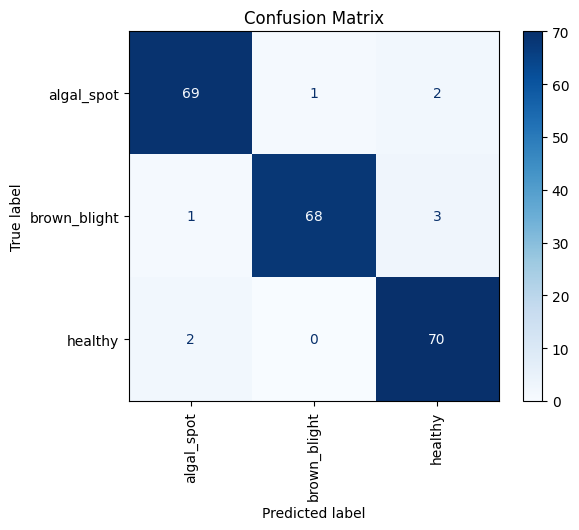

In [27]:
y_true = []
y_pred = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        outputs = vgg16(x_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Save VGG16 Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
save_dir = '/content/drive/MyDrive/Tumor Dataset/Tea_Leaf_Disease'
os.makedirs(save_dir, exist_ok=True)


model_save_path = os.path.join(save_dir, 'Tea Leaf Deasease.pth')


torch.save(vgg16.state_dict(), model_save_path)
print(f"\n✅ Model saved successfully at: {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Model saved successfully at: /content/drive/MyDrive/Tumor Dataset/Tea_Leaf_Disease/Tea Leaf Deasease.pth
